In [1]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

In [2]:
from top_birds import competition_classes, score_threshold_file

2024-03-20 15:19:44.249161: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-20 15:19:45.177141: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 15:19:45.177263: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 15:19:45.387567: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-20 15:19:45.773065: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-20 15:19:45.778508: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
x = pd.read_pickle('scores.pkl')[['primary_index','scores']]

In [4]:
def true_thresh(row):
    return row.scores[row.primary_index]

def tp_fp(row, thresh):
    idx, scores = row[['primary_index', 'scores']]
    is_on = scores >= thresh
    true_pos = int(is_on[idx])
    false_alarms = np.r_[is_on[:idx], is_on[idx+1:]].sum()
    return true_pos, false_alarms

def hit_false_alarm(row, thresh):
    hits, false_alarms = row.apply(lambda x: tp_fp(x, thresh), axis=1, result_type='expand').sum()
    return thresh, hits, false_alarms

In [5]:
thresholds_file = 'thresholds.pkl'
all_thresh = np.sort(np.array(x.apply(true_thresh, axis=1)))
if os.path.exists(thresholds_file):
    thresh_df = pd.read_pickle(thresholds_file)
else:
    thresh_df = pd.DataFrame([hit_false_alarm(x, thresh) for thresh in all_thresh],
                             columns=['threshold', 'hits', 'falsealarms'])
    thresh_df.to_pickle(thresholds_file)

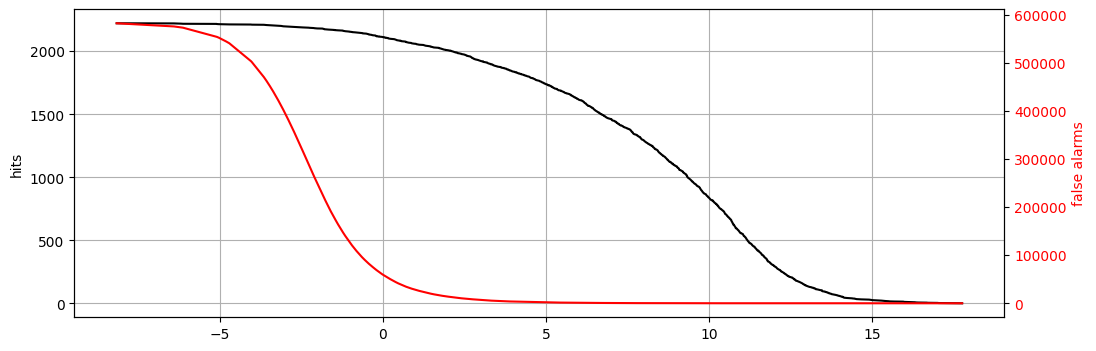

In [6]:
# https://www.statology.org/matplotlib-two-y-axes/
fig, axes = plt.subplots(1, 1, figsize=(12,4))
axes.plot(thresh_df['threshold'],thresh_df['hits'], 'k')
axes.set_ylabel('hits', color='k')
axes.grid()
axes2 = axes.twinx()
axes2.plot(thresh_df['threshold'],thresh_df['falsealarms'], 'r')
axes2.set_ylabel('false alarms', color='r')
axes2.tick_params(labelcolor='r')

In [7]:
def row_acc(row):
    return int(row.primary_index == row.scores.argmax())

In [8]:
x.apply(row_acc, axis=1).sum() / len(x)

0.7376237623762376

In [9]:
def roc_without_pos(neg_scores):
    def fp_without_pos(rate):
        return len(np.asarray(rate <= neg_scores).nonzero()[0]) / len(neg_scores)
    all_thresh = np.concatenate([[np.inf], sorted(set(neg_scores), reverse=True)])
    fpr = np.array([fp_without_pos(t) for t in all_thresh])
    tpr = None
    return fpr, tpr, all_thresh
    
def do_roc(id, target_fpr=.01):
    y_true = x['primary_index'] == id
    y_score = x['scores'].map(lambda x: x[id])
    num_pos = y_true.sum()
    if num_pos == 0:
        fpr, tpr, all_thresh = roc_without_pos(y_score)
    else:
        fpr, tpr, all_thresh = metrics.roc_curve(y_true, y_score, drop_intermediate=False)
    thresh_idx = np.asarray(fpr <= target_fpr ).nonzero()[0][-1]
    return {'n': num_pos,
            'fpr': fpr,
            'tpr': tpr,
            'all_thresh': all_thresh,
            'thresh_idx': thresh_idx,
            'thresh': all_thresh[thresh_idx],}

In [10]:
roc_dict = {idx: do_roc(idx) for idx in range(264)}
median_thresh = np.median(np.array([roc['thresh'] for roc in roc_dict.values()]))
for idx in range(264):
    above_median_thresh = roc_dict[idx]['all_thresh'] >= median_thresh
    roc_dict[idx]['fpr_median_thresh'] = roc_dict[idx]['fpr'][above_median_thresh][-1]
pickle.dump(median_thresh, open(score_threshold_file, 'wb'))
median_thresh

3.1288779973983765

In [11]:
for idx, roc in roc_dict.items():
    thresh_idx = roc['thresh_idx']
    print(f"{idx:02} {roc['n']:02} {thresh_idx:02} {roc['thresh']:.04f}    {roc['fpr'][thresh_idx]:.03f} {roc['fpr_median_thresh']:.03f}", end='')
    if roc['tpr'] is not None:
        print(f"    {roc['tpr'][thresh_idx]:.03f}  ", end='')
    print('')

00 15 35 3.6872    0.010 0.015    0.867  
01 06 27 2.2653    0.010 0.005    0.833  
02 08 28 2.3020    0.010 0.005    0.750  
03 11 33 3.5465    0.010 0.012    1.000  
04 22 38 4.5952    0.010 0.026    0.727  
05 07 28 1.9441    0.010 0.004    0.857  
06 09 31 2.1649    0.010 0.005    1.000  
07 08 30 3.6966    0.010 0.013    1.000  
08 13 35 3.7640    0.010 0.019    1.000  
09 09 29 1.8492    0.010 0.001    0.778  
10 15 34 1.6166    0.010 0.003    0.800  
11 08 29 2.7721    0.010 0.008    0.875  
12 04 25 2.7270    0.010 0.007    0.750  
13 03 25 3.3890    0.010 0.011    1.000  
14 10 32 2.5174    0.010 0.006    1.000  
15 00 22 3.3180    0.010 0.011
16 09 28 4.8938    0.010 0.024    0.667  
17 15 36 1.7577    0.010 0.005    0.933  
18 13 33 2.9915    0.010 0.008    0.846  
19 12 33 4.5771    0.010 0.021    0.917  
20 08 29 2.1395    0.010 0.006    0.875  
21 09 31 1.8200    0.010 0.005    1.000  
22 17 39 3.6170    0.010 0.017    1.000  
23 05 24 2.6348    0.010 0.006    0.600  
24 

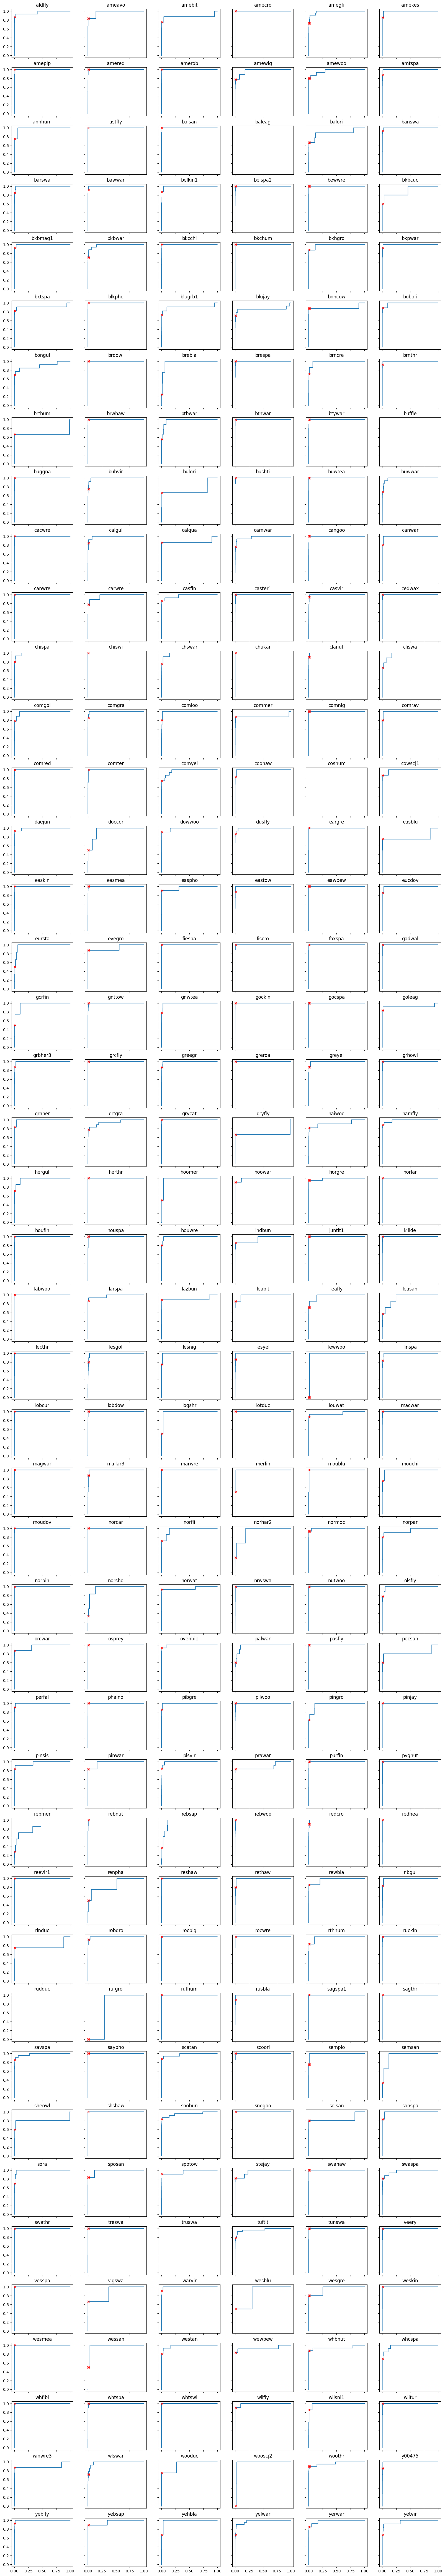

In [12]:
fig, axs = plt.subplots(264//6, 6, figsize=(20,120), sharex=True,sharey=True)
for idx, ax in enumerate( axs.flatten() ):
    roc = do_roc(idx)
    ax.set_title(competition_classes[idx])
    if roc['n'] > 0:
        fpr, tpr, thresh_idx = roc['fpr'], roc['tpr'], roc['thresh_idx']
        ax.plot(fpr, tpr)
        ax.plot(fpr[thresh_idx], tpr[thresh_idx], 'rx')
        ax.plot(fpr[thresh_idx+1], tpr[thresh_idx+1], 'r+')